In [1]:
#!pip install plotly
#!pip install ftfy

In [2]:
# Standard Imports
import nltk
import pandas                        as pd
import numpy                         as np
import seaborn                       as sns
import matplotlib.pyplot             as plt
import re
import ftfy
from IPython.display                 import display_html
from IPython.core.display            import display, HTML

# Proprocessing, Modeling, & Evaluation
from nltk.corpus                     import stopwords
from nltk.stem                       import WordNetLemmatizer
from nltk.tokenize                   import RegexpTokenizer 
from sklearn.ensemble                import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection         import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics                 import accuracy_score, recall_score, roc_auc_score, matthews_corrcoef,roc_curve,precision_score,auc,make_scorer,precision_recall_curve
from sklearn.pipeline                import Pipeline
from sklearn.svm                     import SVC
#from sklearn.tree                    import DecisionTreeClassifier
from sklearn                         import model_selection
#from xgboost                         import XGBClassifier
from sklearn.feature_selection       import chi2,SelectKBest
   

# Custom Modules
import graphs
import metrics


# Notebook settings & styles
sns.set(style = "white", palette = "deep")
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

In [3]:
Annotated_Sample = pd.read_csv('./Reddit Eczema_All_20201201_Annotated_Sample.csv')

In [4]:
stop_words     = stopwords.words('english')

##stopwords.extend(new_stopwords)

# Instantiating the lemmatizier and tokenizer
lemmatizer = WordNetLemmatizer()
tokenizer  = RegexpTokenizer(r'\w+')

In [5]:
def cleaning_data(dataframe):
   
    if 'Annotation' in dataframe :
        dataframe["label"] = dataframe["Annotation"].apply(lambda x: 1 if x == "i" else 0)
    
    #Annotated_Sample.drop(columns=['Annotation'],inplace=True)
    dataframe.rename(columns={'Author':'author'},inplace=True)
    
    #lower case
    
    #dataframe["body"] = dataframe["body"].astype(str)
    
    dataframe["body"] = dataframe["body"].str.lower()
    
    dataframe ["body"] = dataframe ["body"].map(ftfy.fix_encoding)
    
    #remove URL
    dataframe["body"] = dataframe["body"].str.replace("http\S+", "")
    
    # Setting up the lemmatizer

    lemmatized_posts = []

    for post in dataframe["body"]:
        tokens = tokenizer.tokenize(post)
        post   = [lemmatizer.lemmatize(post) for post in tokens]
        lemmatized_posts.append(" ".join(post))

    
    #remove none letters
    
    #dataframe["body"] =  dataframe["body"].apply(lambda x: re.sub(r'[^a-z]',' ',str(x)))
    

    # Appending the lemmatized posts to the dataframe

    dataframe["lemmatized_text"] = lemmatized_posts

    # Checking the head of the dataframe
    #dataframe.head()

    return dataframe


In [6]:
Annotated_Sample = cleaning_data(Annotated_Sample)
#HTML(Annotated_Sample.to_html())

/var/folders/70/8trc80rn081bqmp225zwyp8r0000gq/T/ipykernel_65314/4089405346.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe["body"] = dataframe["body"].str.replace("http\S+", "")


# Modelling

__Create Test and Training data split__

In [7]:
X = Annotated_Sample["lemmatized_text"]
y = Annotated_Sample["label"]

# The random state ensures reproducability
# The stratify argument preserves the distribution of classes

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify     = y)

## Support Vector Classifier

A support vector machine (in this case a classifier) is at its core a linear model. However, instead of running like a logistic regression, it seeks to linearly separate the data. To do that, it uses a kernel to raise the data into n-dimensional space. It then uses a line, plane (3-dimensional line), or hyperplane (greater than 3-dimensions) to delineate the data



### Count Vector

In [8]:
# Setting up the count vector pipeline
cvec_svc_pipe = Pipeline([("cvec", CountVectorizer()),
                          ("bestf",SelectKBest()),
                          ("svc", SVC())])

#### Count Vector + SVM Kernel - Linear 


In [9]:
# Setting CVEC and pipe hyperparameters
cvec_linear_pipe_params = {"cvec__max_features": [None], 
                    "cvec__ngram_range" : [(1,1)], 
                    "cvec__stop_words"  : [stop_words],
                    "cvec__binary"      : [False],
                    "cvec__min_df"      : [2],
                    "bestf__score_func" : [chi2],
                    "bestf__k"          : [250,300,350],       
                    "svc__C"            : [0.0001,0.0005,0.001,0.005,0.01,0.1,0.2],
                    "svc__kernel"       : ["linear"],
                    "svc__probability"  : [True]}

                   
# Instantiating the grid search

cvec_linear_svc_gs = GridSearchCV(cvec_svc_pipe, 
                           param_grid = cvec_linear_pipe_params, 
                           cv         = 10,
                           scoring    = 'roc_auc'
                           )

                    
# Fitting the model to the training data

cvec_linear_svc_gs.fit(X_train, y_train)

# print best parameter after tuning 
print(cvec_linear_svc_gs.best_params_) 

{'bestf__k': 300, 'bestf__score_func': <function chi2 at 0x7ff17fbf9ca0>, 'cvec__binary': False, 'cvec__max_features': None, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then',

In [10]:
results_linear = pd.DataFrame(cvec_linear_svc_gs.cv_results_)

#results.head()
results_linear = results_linear.sort_values(by='rank_test_score')

#results_linear.head(10)
#results_linear.round(3).head(20)
results_linear[['param_bestf__k','param_cvec__binary','param_svc__C', 'param_cvec__min_df','param_svc__kernel','mean_test_score','std_test_score','rank_test_score']].round(3).head(5)

,param_bestf__k,param_cvec__binary,param_svc__C,param_cvec__min_df,param_svc__kernel,mean_test_score,std_test_score,rank_test_score
8,300,False,0.0005,2,linear,0.867,0.049,1
9,300,False,0.001,2,linear,0.864,0.048,2
1,250,False,0.0005,2,linear,0.864,0.047,3
12,300,False,0.1,2,linear,0.864,0.048,4
5,250,False,0.1,2,linear,0.863,0.050,5


In [11]:
# Generating training predictions

cvec_linear_train_preds = cvec_linear_svc_gs.predict(X_train)

cvec_linear_train_score = cvec_linear_svc_gs.decision_function(X_train)

# Training metrics

summary_training_linear=metrics.binary_classification_summary(y_train, cvec_linear_train_preds,cvec_linear_train_score,'summary_training_linear')

0.9651385156088484


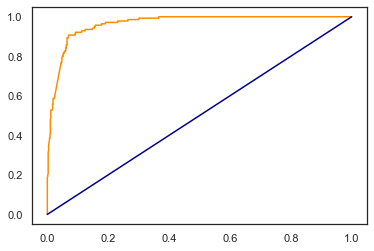

In [12]:
fprs,tprs,thresholds = roc_curve(y_train, cvec_linear_train_score)
AUROC = auc(fprs,tprs)
plt.plot(fprs,tprs,color='darkorange')
plt.plot([0,1],[0,1],color='darkblue')
print(AUROC)

#### Count Vector + SVM Kernel - rbf 


In [13]:
# Setting CVEC and pipe hyperparameters

cvec_rbf_pipe_params = {"cvec__max_features": [None], 
                    "cvec__ngram_range" : [(1,1)], 
                    "cvec__stop_words"  : [stop_words],
                    "cvec__binary"      : [False],
                    "cvec__min_df"      : [2],
                    "bestf__score_func" : [chi2],
                    "bestf__k"          : [300,350,400,450,500], 
                    "svc__C"            : [0.001,0.005,0.01,0.05,0.1,1,100],
                    "svc__gamma"        : [0.02,0.1,5],
                    "svc__kernel"       : ["rbf"],
                    "svc__probability"  : [True]}

                    
# Instantiating the grid search

cvec_rbf_svc_gs = GridSearchCV(cvec_svc_pipe, 
                           param_grid = cvec_rbf_pipe_params, 
                           cv         = 10,
                           scoring    = 'roc_auc'
                           )

                    
# Fitting the model to the training data

cvec_rbf_svc_gs.fit(X_train, y_train)

# print best parameter after tuning 
print(cvec_rbf_svc_gs.best_params_) 

{'bestf__k': 400, 'bestf__score_func': <function chi2 at 0x7ff17fbf9ca0>, 'cvec__binary': False, 'cvec__max_features': None, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then',

In [14]:
results_rbf = pd.DataFrame(cvec_rbf_svc_gs.cv_results_)
results_rbf = results_rbf.sort_values(by='rank_test_score')
#results_rbf.head()

results_rbf[['param_bestf__k','param_cvec__binary','param_svc__C', 'param_svc__kernel','param_svc__gamma','mean_test_score','std_test_score', 'rank_test_score']].round(3).head(5)

,param_bestf__k,param_cvec__binary,param_svc__C,param_svc__kernel,param_svc__gamma,mean_test_score,std_test_score,rank_test_score
49,400,False,0.01,rbf,0.1,0.883,0.045,1
52,400,False,0.05,rbf,0.1,0.883,0.046,2
58,400,False,1,rbf,0.1,0.883,0.045,3
55,400,False,0.1,rbf,0.1,0.883,0.045,4
76,450,False,0.1,rbf,0.1,0.883,0.045,5


In [15]:
# Generating training predictions

cvec_rbf_train_preds = cvec_rbf_svc_gs.predict(X_train)

cvec_rbf_train_score = cvec_rbf_svc_gs.decision_function(X_train)

# Training metrics

summary_training_rbf=metrics.binary_classification_summary(y_train, cvec_rbf_train_preds,cvec_rbf_train_score,'summary_training_rbf')

In [16]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_train, 
                                   cvec_rbf_train_preds,
                                   columns = ["Predicted Related", "Predicted Irrelated"],
                                   index   = ["Actual Related", "Actual Irrelated"])

,Predicted Related,Predicted Irrelated
Actual Related,691,0
Actual Irrelated,140,0


0.973857763076287


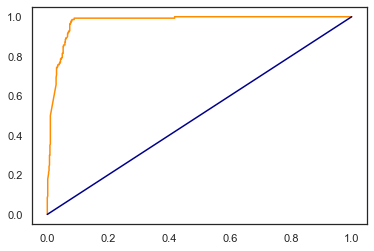

In [17]:
fprs,tprs,thresholds = roc_curve(y_train, cvec_rbf_train_score)
AUROC = auc(fprs,tprs)
plt.plot(fprs,tprs,color='darkorange')
plt.plot([0,1],[0,1],color='darkblue')
print(AUROC)

### Fining Tuning with Threshold Moving

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):

    fscore = (2*precisions*recalls)/(precisions+recalls)
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, fscore[:-1], "k:", label="fscore")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    ix=np.argmax(fscore)
    plt.scatter(thresholds[ix],fscore[ix],marker='X',color='red',label='Best')
    #print('Best Threshold=%f, F-score=%.3f'%(thresholds[ix],fscore[ix]))
    threshold_= thresholds[ix]
    return threshold_


In [19]:
# This function allows for dataframes to be displayed side-by-side

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw = True)

In [20]:
def adjusted_prediction(y_scores,t):
    return [1 if y >= t else 0 for y in y_scores]

#### Linear Kernel

In [21]:
precision_linear, recall_linear, thresholds_linear = precision_recall_curve(y_train, cvec_linear_train_score)

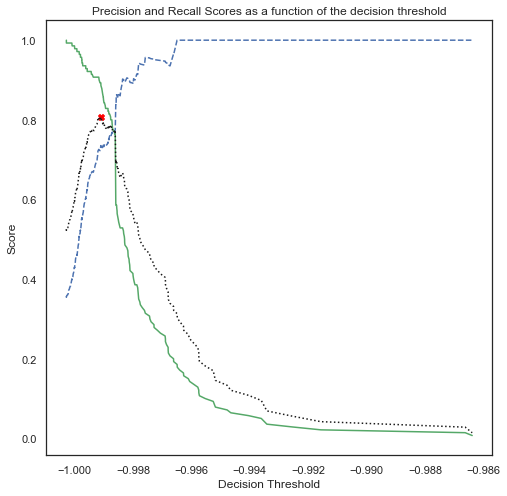

In [22]:
# plot the precion, recall and f score a function of the decision threshold based on the linear kernal

adjusted_threshold_linear=plot_precision_recall_vs_threshold(precision_linear, recall_linear, thresholds_linear)

In [23]:
print(adjusted_threshold_linear)

-0.9991006884379525


In [24]:
cvec_linear_train_new_preds=adjusted_prediction(cvec_linear_train_score,adjusted_threshold_linear)

In [25]:
# Generating a new confusion matrix on the training results

metrics.confusion_matrix_dataframe(y_train, 
                                   cvec_linear_train_new_preds,
                                   columns = ["Predicted Related (Ajusted)", "Predicted Irrelated(Ajusted)"],
                                   index   = ["Actual Related", "Actual Irrelated"])

,Predicted Related (Ajusted),Predicted Irrelated(Ajusted)
Actual Related,646,45
Actual Irrelated,15,125


In [26]:
summary_training_linear_new=metrics.binary_classification_summary(y_train, cvec_linear_train_new_preds,cvec_linear_train_score,'summary_training_linear_adjusted')

#### rbf Kernal

In [27]:
precision_rbf, recall_rbf, thresholds_rbf = precision_recall_curve(y_train, cvec_rbf_train_score)


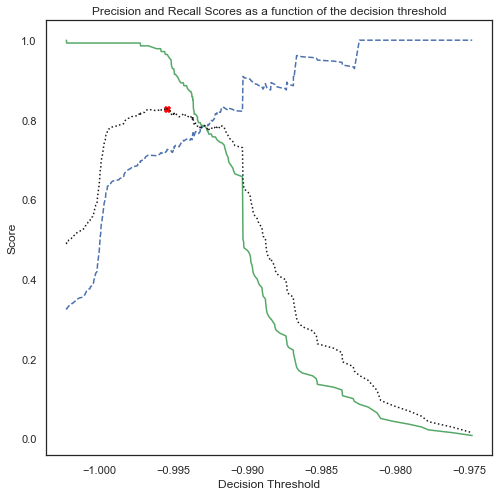

In [28]:
# plot the precion, recall and f score a function of the decision threshold based on the rbf kernal

adjusted_threshold_rbf = plot_precision_recall_vs_threshold(precision_rbf, recall_rbf, thresholds_rbf)

In [29]:
print(adjusted_threshold_rbf)

-0.9954405864941994


In [30]:
cvec_rbf_train_new_preds=adjusted_prediction(cvec_rbf_train_score,adjusted_threshold_rbf)

In [31]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_train, 
                                   cvec_rbf_train_new_preds,
                                   columns = ["Predicted Related (Ajusted)", "Predicted Irrelated(Ajusted)"],
                                   index   = ["Actual Related", "Actual Irrelated"])

,Predicted Related (Ajusted),Predicted Irrelated(Ajusted)
Actual Related,640,51
Actual Irrelated,5,135


In [32]:
summary_training_rbf_new=metrics.binary_classification_summary(y_train, cvec_rbf_train_new_preds,cvec_rbf_train_score,'summary_training_rbf_adjusted')


In [33]:
display_side_by_side(summary_training_linear,summary_training_linear_new,summary_training_rbf,summary_training_rbf_new)

,summary_training_linear
Accuracy,0.831528
Sensitivity,0.000000
Specificity,1.000000
AUROC,0.965139
,summary_training_linear_adjusted
Accuracy,0.927798
Sensitivity,0.892857
Specificity,0.934877
AUROC,0.965139
,summary_training_rbf


**TFIDF Vectorizer**

#### Linear Kernal

In [34]:
# Setting up the pipeline

tvec_svc_pipe = Pipeline([("tvec", TfidfVectorizer()), 
                          ("bestf",SelectKBest()),
                          ("svc", SVC())])

# Setting TFIDF and pipe hyperparameters

tvec_linear_pipe_params = {"tvec__max_features": [None], 
                    "tvec__ngram_range" : [(1,2)], 
                    "tvec__stop_words"  : [stop_words],
                    "tvec__binary"      : [True,False],
                    "tvec__min_df"      : [2],
                    "bestf__score_func" : [chi2],
                    "bestf__k"          : [100,200,300,400,500], 
                    "svc__C"            : [0.001,0.01,0.1,1,10],
                    "svc__kernel"       : ["linear"],
                    "svc__probability"  : [True]}
                    
# Instantiating the grid search

tvec_linear_svc_gs = GridSearchCV(tvec_svc_pipe, 
                           param_grid = tvec_linear_pipe_params, 
                           cv         = 10,
                           scoring    = 'roc_auc'
                            )


# Fitting the model to the training data

tvec_linear_svc_gs.fit(X_train, y_train);

# print best parameter after tuning 
print(tvec_linear_svc_gs.best_params_) 


{'bestf__k': 400, 'bestf__score_func': <function chi2 at 0x7ff17fbf9ca0>, 'svc__C': 1, 'svc__kernel': 'linear', 'svc__probability': True, 'tvec__binary': False, 'tvec__max_features': None, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 

In [35]:
tresults_linear = pd.DataFrame(tvec_linear_svc_gs.cv_results_)

#results.head()
tresults_linear = tresults_linear.sort_values(by='rank_test_score')

#results_linear.round(3).head(20)
tresults_linear[['param_bestf__k','param_tvec__binary','param_svc__C', 'param_tvec__min_df','param_svc__kernel','mean_test_score','std_test_score','rank_test_score']].round(3).head(5)

,param_bestf__k,param_tvec__binary,param_svc__C,param_tvec__min_df,param_svc__kernel,mean_test_score,std_test_score,rank_test_score
37,400,False,1,2,linear,0.836,0.050,1
45,500,False,0.1,2,linear,0.836,0.053,2
47,500,False,1,2,linear,0.836,0.056,3
35,400,False,0.1,2,linear,0.835,0.052,4
33,400,False,0.01,2,linear,0.834,0.053,5


In [36]:
# Generating training predictions

tvec_linear_train_preds = tvec_linear_svc_gs.predict(X_train)
tvec_linear_train_score = tvec_linear_svc_gs.decision_function(X_train)

# Training metrics

summary_training_tlinear = metrics.binary_classification_summary(y_train, tvec_linear_train_preds,tvec_linear_train_score,'summary_training_linear_tf')

In [37]:
precision_tlinear, recall_tlinear, thresholds_tlinear = precision_recall_curve(y_train, tvec_linear_train_score)

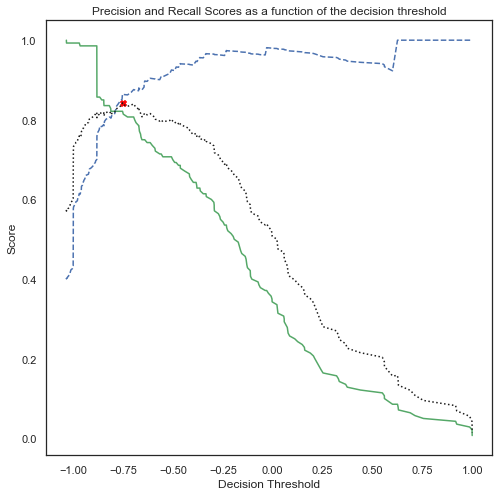

In [38]:
# plot the precion, recall and f score a function of the decision threshold based on the linear kernal

adjusted_threshold_tlinear=plot_precision_recall_vs_threshold(precision_tlinear, recall_tlinear, thresholds_tlinear)

In [39]:
tvec_linear_train_new_preds=adjusted_prediction(tvec_linear_train_score,adjusted_threshold_tlinear)

In [40]:
summary_training_tlinear_new=metrics.binary_classification_summary(y_train, tvec_linear_train_new_preds,tvec_linear_train_score,'summary_training_tlinear_adjusted')

#### RBF Kernel 

In [41]:
# Setting TFIDF and pipe hyperparameters

tvec_rbf_pipe_params = {"tvec__max_features": [None], 
                    "tvec__ngram_range" : [(1,2)], 
                    "tvec__stop_words"  : [stop_words],
                    "tvec__binary"      : [True,False],
                    "tvec__min_df"      : [2],
                    "bestf__score_func" : [chi2],
                    "bestf__k"          : [100,200,300,400,500], 
                    "svc__C"            : [0.001,0.005,0.01,0.05,0.1,0.5,1],
                    "svc__gamma"        : [0.001,0.005,0.01,0.02,0.05],
                    "svc__kernel"       : ["rbf"],
                    "svc__probability"  : [True]}
                    
# Instantiating the grid search

tvec_rbf_svc_gs = GridSearchCV(tvec_svc_pipe, 
                           param_grid = tvec_rbf_pipe_params, 
                           cv         = 10,
                           scoring    = 'roc_auc')


# Fitting the model to the training data

tvec_rbf_svc_gs.fit(X_train, y_train);

# print best parameter after tuning 
print(tvec_rbf_svc_gs.best_params_) 


{'bestf__k': 500, 'bestf__score_func': <function chi2 at 0x7ff17fbf9ca0>, 'svc__C': 0.1, 'svc__gamma': 0.005, 'svc__kernel': 'rbf', 'svc__probability': True, 'tvec__binary': False, 'tvec__max_features': None, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 

In [42]:
tresults_rbf = pd.DataFrame(tvec_rbf_svc_gs.cv_results_)
tresults_rbf = tresults_rbf.sort_values(by='rank_test_score')
#results_rbf.head()

tresults_rbf[['param_bestf__k','param_tvec__binary','param_svc__C', 'param_svc__kernel','param_svc__gamma','mean_test_score','std_test_score', 'rank_test_score']].round(3).head(5)

,param_bestf__k,param_tvec__binary,param_svc__C,param_svc__kernel,param_svc__gamma,mean_test_score,std_test_score,rank_test_score
323,500,False,0.1,rbf,0.005,0.843,0.047,1
227,400,False,0.005,rbf,0.02,0.843,0.041,2
237,400,False,0.01,rbf,0.02,0.843,0.041,2
244,400,True,0.05,rbf,0.01,0.843,0.052,4
295,500,False,0.005,rbf,0.01,0.843,0.043,5


In [43]:
# Generating training predictions

tvec_rbf_train_preds = tvec_rbf_svc_gs.predict(X_train)
tvec_rbf_train_score = tvec_rbf_svc_gs.decision_function(X_train)

# Training metrics

summary_training_trbf = metrics.binary_classification_summary(y_train, tvec_rbf_train_preds,tvec_rbf_train_score,'summary_training_rbf_tf')

In [44]:
precision_trbf, recall_trbf, thresholds_trbf = precision_recall_curve(y_train, tvec_rbf_train_score)

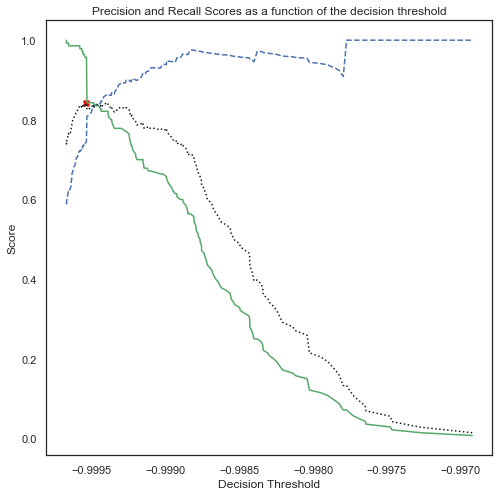

In [45]:
# plot the precion, recall and f score a function of the decision threshold based on the linear kernal

adjusted_threshold_trbf = plot_precision_recall_vs_threshold(precision_trbf, recall_trbf, thresholds_trbf)

In [46]:
tvec_rbf_train_new_preds = adjusted_prediction(tvec_rbf_train_score,adjusted_threshold_trbf)

In [47]:
summary_training_trbf_new = metrics.binary_classification_summary(y_train, tvec_rbf_train_new_preds,tvec_rbf_train_score,'summary_training_trbf_adjusted')

# Compare Models

In [48]:
display_side_by_side(summary_training_linear_new,summary_training_rbf_new,summary_training_tlinear_new,summary_training_trbf_new)

,summary_training_linear_adjusted
Accuracy,0.927798
Sensitivity,0.892857
Specificity,0.934877
AUROC,0.965139
,summary_training_rbf_adjusted
Accuracy,0.932611
Sensitivity,0.964286
Specificity,0.926194
AUROC,0.973858
,summary_training_tlinear_adjusted


### Validating on test dataset

In [49]:
# Generating test predictions based on linear kernel

cvec_linear_svc_preds_test       = cvec_linear_svc_gs.predict(X_test)

cvec_linear_svc_score_test       = cvec_linear_svc_gs.decision_function(X_test)


In [50]:
cvec_linear_svc_preds_test_new = adjusted_prediction(cvec_linear_svc_score_test,adjusted_threshold_linear)

In [51]:
summary_linear_test_new = metrics.binary_classification_summary(y_test, cvec_linear_svc_preds_test_new,cvec_linear_svc_score_test,'summary_linear_test_adjusted')

In [52]:
# Generating test predictions based on linear kernel

cvec_rbf_svc_preds_test       = cvec_rbf_svc_gs.predict(X_test)

cvec_rbf_svc_score_test       = cvec_rbf_svc_gs.decision_function(X_test)


In [53]:
cvec_rbf_svc_preds_test_new = adjusted_prediction(cvec_rbf_svc_score_test,adjusted_threshold_rbf)

In [54]:
summary_rbf_test_adjusted = metrics.binary_classification_summary(y_test, cvec_rbf_svc_preds_test_new,cvec_rbf_svc_score_test,'summary_rbf_test_adjusted')

In [55]:
# Generating test predictions based on linear kernel

tvec_linear_svc_preds_test       = tvec_linear_svc_gs.predict(X_test)

tvec_linear_svc_score_test       = tvec_linear_svc_gs.decision_function(X_test)


In [56]:
tvec_linear_svc_preds_test_new=adjusted_prediction(tvec_linear_svc_score_test,adjusted_threshold_tlinear)

In [57]:
summary_tlinear_test_new = metrics.binary_classification_summary(y_test, tvec_linear_svc_preds_test_new,tvec_linear_svc_score_test,'summary_tlinear_test_adjusted')

In [58]:
# Generating test predictions based on rbf kernel

tvec_rbf_svc_preds_test       = tvec_rbf_svc_gs.predict(X_test)

tvec_rbf_svc_score_test       = tvec_rbf_svc_gs.decision_function(X_test)

In [59]:
tvec_rbf_svc_preds_test_new=adjusted_prediction(tvec_rbf_svc_score_test,adjusted_threshold_trbf)

In [60]:
summary_trbf_test_new = metrics.binary_classification_summary(y_test, tvec_rbf_svc_preds_test_new,tvec_rbf_svc_score_test,'summary_trbf_test_adjusted')

In [61]:
display_side_by_side(summary_linear_test_new,summary_rbf_test_adjusted,summary_tlinear_test_new,summary_trbf_test_new)

,summary_linear_test_adjusted
Accuracy,0.794964
Sensitivity,0.680851
Specificity,0.818182
AUROC,0.803215
,summary_rbf_test_adjusted
Accuracy,0.827338
Sensitivity,0.638298
Specificity,0.865801
AUROC,0.828912
,summary_tlinear_test_adjusted


## Use Prediction Model

In [64]:
Model_picked = cvec_rbf_svc_gs

Adjusted_threshold = adjusted_threshold_rbf

In [65]:
def predict(dataframe):

    pred_text = dataframe["lemmatized_text"]
    
    # For cvec models
    
    pred_socre = Model_picked.decision_function(pred_text)
    
    pred_result = adjusted_prediction(pred_socre,adjusted_threshold_rbf)
   
    # pred_result = Model_picked.predict(pred_text) 
       
    vec_predictions = pd.DataFrame([np.array(pred_text),pred_result],index = ["body","label"]).T
    
    dfname =[x for x in globals() if globals()[x] is dataframe][0]
    
    # Saving the dataframes as csvs
    vec_predictions.to_csv("./%s_pred.csv"%(dfname))

In [66]:
eczema_data= pd.read_csv('./eczema-post-all.csv', encoding="iso-8859-1" )


eczema_data.head()

,Unnamed: 0,body
0,0,Looking for that little bit of extra support? ...
1,1,"Hi everyone,\nMy name is Azizah and I am condu..."
2,2,I am currently doing an extended project quali...
3,3,"Hi Alice, \n\nI have Pompholyx. To clear an in..."
4,4,"Hello,\nI am in my third year at Derby Univers..."


In [67]:
eczema_data=eczema_data[eczema_data['body'].notnull()]

In [68]:
eczema_data = cleaning_data(eczema_data)

/var/folders/70/8trc80rn081bqmp225zwyp8r0000gq/T/ipykernel_65314/4089405346.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe["body"] = dataframe["body"].str.replace("http\S+", "")


In [69]:
eczema_data.head()

,Unnamed: 0,body,lemmatized_text
0,0,looking for that little bit of extra support? ...,looking for that little bit of extra support t...
1,1,"hi everyone,\nmy name is azizah and i am condu...",hi everyone my name is azizah and i am conduct...
2,2,i am currently doing an extended project quali...,i am currently doing an extended project quali...
3,3,"hi alice, \n\ni have pompholyx. to clear an in...",hi alice i have pompholyx to clear an infected...
4,4,"hello,\ni am in my third year at derby univers...",hello i am in my third year at derby universit...


In [70]:
predict(eczema_data)